# Project 3: Text Analysis of New York Times Articles

In [1]:
# Run this cell to set up your notebook. 
import warnings
warnings.simplefilter(action="ignore")

import re
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ds100_utils import *

# Ensure that pandas shows at least 280 characters in columns, so we can see full articles.
pd.set_option("max_colwidth", 280)
plt.style.use("fivethirtyeight")
sns.set()
sns.set_context("talk")
sns.set_palette("colorblind")

In this project, I will use the [DistilBERT model](https://medium.com/huggingface/distilbert-8cf3380435b5), a Natural Language Processing (NLP) model designed to capture the context and meaning of words within sentences.


## ⚠️ IMPORTANT NOTE

Due to limited computing resources on DataHub, the cell below **may take a significant amount of time to run** (potentially several minutes). This may also apply to other cells later in the assignment that load and use the NLP model.


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Section 1: Importing the Data

The data for this project is sourced from the [New York Times (NYT) Archive API](https://developer.nytimes.com/docs/archive-product/1/overview), which provides information about articles published in the past.

The file `data/nyt_articles.txt` contains filtered data of specific NYT articles published between 2019 and 2024 (inclusive). Each article discusses trending topics.

<br>

---

### Part 1

Let's examine the contents of the `data/nyt_articles.txt` file.

Using the [`open()` function](https://docs.python.org/3/library/functions.html#open) and the [`read()` method](https://docs.python.org/3/tutorial/inputoutput.html#methods-of-file-objects) of a `python` file object, I read **the first 330 characters** of the file `data/nyt_articles.txt` and store the result in the variable `s1`. Then, print the result to inspect it.

In [2]:
with open("data/nyt_articles.txt") as file:
    s1 = file.read(330)
print(s1)

[{"web_url":"https:\/\/www.nytimes.com\/2019\/01\/01\/us\/politics\/elizabeth-warren-president.html","pub_date":"2019-01-01T05:18:48+0000","lead_paragraph":"Good Tuesday morning and Happy New Year. Here are some of the stories making news in Washington and politics today."},{"web_url":"https:\/\/www.nytimes.com\/2019\/01\/01\/ar


<br>

---

###  Part 2
`pandas` has built-in readers for many different file formats.

I will load the file `data/nyt_articles.txt` as a `DataFrame`, and store it in the variable `news_df`.

In [3]:
news_df = pd.read_json("data/nyt_articles.txt")
news_df.head()

,web_url,pub_date,lead_paragraph
0,https://www.nytimes.com/2019/01/01/us/politics/elizabeth-warren-president.html,2019-01-01T05:18:48+0000,Good Tuesday morning and Happy New Year. Here are some of the stories making news in Washington and politics today.
1,https://www.nytimes.com/2019/01/01/arts/television/whats-on-tv-tuesday-marie-kondo-doctor-who.html,2019-01-01T06:00:04+0000,"Ring in the new year with some organization inspiration, courtesy of Marie Kondo, and the first-ever ""Doctor Who"" New Year’s Day special."
2,https://www.nytimes.com/2019/01/01/travel/three-new-years-resolutions-for-better-travel-in-2019.html,2019-01-01T10:00:06+0000,"It’s not uncommon for people to set unrealistic expectations when making New Year’s resolutions, which likely contributes to most of them failing. Over 90 percent of them do, according to research by the University of Scranton."
3,https://www.nytimes.com/2019/01/01/world/europe/russia-baby-rescue.html,2019-01-01T16:41:24+0000,"MOSCOW — Rescue workers pulled a 10-month-old baby boy alive from a partly collapsed apartment building in central Russia on Tuesday, calling him a ""New Year miracle"" after he survived in the rubble for more than 35 hours in freezing temperatures."
4,https://www.nytimes.com/2019/01/01/world/europe/germany-foreigners-attack.html,2019-01-01T17:57:51+0000,"BERLIN — Targeting foreigners, a man repeatedly drove his car at pedestrians celebrating New Year’s Eve in western Germany, injuring four people before being arrested, the police and prosecutors said Tuesday."


<br/>

<hr style="border: 1px solid #fdb515;" />

##  Section 2: Topic Trends Over Time

Now that the NYT data is loaded, i'll analyze trends in different topics. This will help understand how various subjects have evolved over the years and identify any significant patterns or shifts in public interest.

I will start by extracting date and time information from the articles and then proceed to analyze the frequency and context of specific topics mentioned in the articles.


<br>


---

###  Part 1

In this part, I will process the `pub_date` column of our dataset to canonicalize time-related data.
This will help me investigate the trend of news articles across units of time like years, months, and seasons.


I will Create a new `DataFrame` called `dates` that contains:
1. The same index as `news_df`
2. Three columns: `Month`, `Year`, and `Minute`, which contain the month, year, and minute, respectively, that each article was published.

Additionally, convert all numerical values (`Month`, `Year`, `Minute`) to type `int`.

In [4]:
dates = news_df["pub_date"].str.extract(r"(?P<Year>\d{4})-(?P<Month>\d{2})-\d{2}T\d{2}:(?P<Minute>\d{2})")
dates = dates.astype(int)
dates.index = news_df.index
dates

,Year,Month,Minute
0,2019,1,18
1,2019,1,0
2,2019,1,0
3,2019,1,41
4,2019,1,57
...,...,...,...
1880,2024,12,0
1881,2024,12,14
1882,2024,12,16
1883,2024,12,18



I aim to analyze topic trends over time by merging news article data with corresponding date and time data. 

Use the `pd.DataFrame.merge` [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) to merge the `dates` `DataFrame` with the `news_df` `DataFrame`. Ensure that `news_df` is the left `DataFrame` and `dates` is the right `DataFrame` in the merge operation.

Assign the merged `DataFrame` to a variable named `news_df_dates`.

In [5]:
news_df_dates = news_df.merge(dates, left_index=True, right_index=True)
news_df_dates

,web_url,pub_date,lead_paragraph,Year,Month,Minute
0,https://www.nytimes.com/2019/01/01/us/politics/elizabeth-warren-president.html,2019-01-01T05:18:48+0000,Good Tuesday morning and Happy New Year. Here are some of the stories making news in Washington and politics today.,2019,1,18
1,https://www.nytimes.com/2019/01/01/arts/television/whats-on-tv-tuesday-marie-kondo-doctor-who.html,2019-01-01T06:00:04+0000,"Ring in the new year with some organization inspiration, courtesy of Marie Kondo, and the first-ever ""Doctor Who"" New Year’s Day special.",2019,1,0
2,https://www.nytimes.com/2019/01/01/travel/three-new-years-resolutions-for-better-travel-in-2019.html,2019-01-01T10:00:06+0000,"It’s not uncommon for people to set unrealistic expectations when making New Year’s resolutions, which likely contributes to most of them failing. Over 90 percent of them do, according to research by the University of Scranton.",2019,1,0
3,https://www.nytimes.com/2019/01/01/world/europe/russia-baby-rescue.html,2019-01-01T16:41:24+0000,"MOSCOW — Rescue workers pulled a 10-month-old baby boy alive from a partly collapsed apartment building in central Russia on Tuesday, calling him a ""New Year miracle"" after he survived in the rubble for more than 35 hours in freezing temperatures.",2019,1,41
4,https://www.nytimes.com/2019/01/01/world/europe/germany-foreigners-attack.html,2019-01-01T17:57:51+0000,"BERLIN — Targeting foreigners, a man repeatedly drove his car at pedestrians celebrating New Year’s Eve in western Germany, injuring four people before being arrested, the police and prosecutors said Tuesday.",2019,1,57
...,...,...,...,...,...,...
1880,https://www.nytimes.com/2024/12/31/crosswords/wordle-review-1292.html,2024-12-31T11:00:02+0000,"Welcome to The Wordle Review. Be warned: This page contains spoilers for today’s puzzle. Solve Wordle first, or scroll at your own risk.",2024,12,0
1881,https://www.nytimes.com/2024/12/31/world/europe/new-years-eve-edinburgh-hogmanay-weather-canceled.html,2024-12-31T11:14:16+0000,"The famed Hogmanay street party on New Year’s Eve in Edinburgh, the Scottish capital, has been canceled because of forecasts of rain, strong winds and snow.",2024,12,14
1882,https://www.nytimes.com/2024/12/31/us/puerto-rico-power-blackout.html,2024-12-31T14:16:12+0000,"A sweeping blackout hit Puerto Rico early Tuesday morning, plunging nearly all of the island into darkness on New Year’s Eve.",2024,12,16
1883,https://www.nytimes.com/2024/12/31/world/new-years-eve-photos.html,2024-12-31T15:18:44+0000,"In plazas and parks and bars and homes across the globe, people gathered to commemorate the end of 2024 and welcome the New Year. Bold swimmers plunged into a frigid lake in Switzerland, joggers in Poland took one last whimsical run of the year and fireworks crackled in citie...",2024,12,18


I will add a column to `news_df_dates` called `Quarter` that contains the [fiscal quarter](https://www.investopedia.com/terms/q/quarter.asp#:~:text=The%20standard%20calendar%20quarters%20that,August%2C%20and%20September%20(Q3)) each news article was published.

Each value of `Quarter` should be in the format `"<Year>Q<Quarter Number>"`.

For example:
- A news article published in May 2021 will have its `Quarter` value as `"2021Q2"`.
- A news article published in October 2023 will have its `Quarter` value as `"2023Q4"`.

In [6]:
news_df_dates["Quarter"] = news_df_dates["Year"].astype(str) + "Q" + ((news_df_dates["Month"] - 1) // 3 + 1).astype(str)
news_df_dates

,web_url,pub_date,lead_paragraph,Year,Month,Minute,Quarter
0,https://www.nytimes.com/2019/01/01/us/politics/elizabeth-warren-president.html,2019-01-01T05:18:48+0000,Good Tuesday morning and Happy New Year. Here are some of the stories making news in Washington and politics today.,2019,1,18,2019Q1
1,https://www.nytimes.com/2019/01/01/arts/television/whats-on-tv-tuesday-marie-kondo-doctor-who.html,2019-01-01T06:00:04+0000,"Ring in the new year with some organization inspiration, courtesy of Marie Kondo, and the first-ever ""Doctor Who"" New Year’s Day special.",2019,1,0,2019Q1
2,https://www.nytimes.com/2019/01/01/travel/three-new-years-resolutions-for-better-travel-in-2019.html,2019-01-01T10:00:06+0000,"It’s not uncommon for people to set unrealistic expectations when making New Year’s resolutions, which likely contributes to most of them failing. Over 90 percent of them do, according to research by the University of Scranton.",2019,1,0,2019Q1
3,https://www.nytimes.com/2019/01/01/world/europe/russia-baby-rescue.html,2019-01-01T16:41:24+0000,"MOSCOW — Rescue workers pulled a 10-month-old baby boy alive from a partly collapsed apartment building in central Russia on Tuesday, calling him a ""New Year miracle"" after he survived in the rubble for more than 35 hours in freezing temperatures.",2019,1,41,2019Q1
4,https://www.nytimes.com/2019/01/01/world/europe/germany-foreigners-attack.html,2019-01-01T17:57:51+0000,"BERLIN — Targeting foreigners, a man repeatedly drove his car at pedestrians celebrating New Year’s Eve in western Germany, injuring four people before being arrested, the police and prosecutors said Tuesday.",2019,1,57,2019Q1
...,...,...,...,...,...,...,...
1880,https://www.nytimes.com/2024/12/31/crosswords/wordle-review-1292.html,2024-12-31T11:00:02+0000,"Welcome to The Wordle Review. Be warned: This page contains spoilers for today’s puzzle. Solve Wordle first, or scroll at your own risk.",2024,12,0,2024Q4
1881,https://www.nytimes.com/2024/12/31/world/europe/new-years-eve-edinburgh-hogmanay-weather-canceled.html,2024-12-31T11:14:16+0000,"The famed Hogmanay street party on New Year’s Eve in Edinburgh, the Scottish capital, has been canceled because of forecasts of rain, strong winds and snow.",2024,12,14,2024Q4
1882,https://www.nytimes.com/2024/12/31/us/puerto-rico-power-blackout.html,2024-12-31T14:16:12+0000,"A sweeping blackout hit Puerto Rico early Tuesday morning, plunging nearly all of the island into darkness on New Year’s Eve.",2024,12,16,2024Q4
1883,https://www.nytimes.com/2024/12/31/world/new-years-eve-photos.html,2024-12-31T15:18:44+0000,"In plazas and parks and bars and homes across the globe, people gathered to commemorate the end of 2024 and welcome the New Year. Bold swimmers plunged into a frigid lake in Switzerland, joggers in Poland took one last whimsical run of the year and fireworks crackled in citie...",2024,12,18,2024Q4


<br>

---

###  Part 2

Next, I will investigate popularity trends of the following four topics: [New Year](https://en.wikipedia.org/wiki/New_Year), [Wordle](https://www.nytimes.com/games/wordle/index.html), [Zoom](https://www.zoom.com/), and [GPT models](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer).

For each topic, I will add an integer column to `news_df_dates` indicating the number of times the topic is mentioned in the `lead_paragraph` (i.e., first paragraph) of each article. 

- The columns should be named `"New Year"`,  `"Zoom"`, `"Wordle"`, and `"GPT Model"`.

Here are the definitions of a single "mention" of each topic:
- New Year: An appearance of `"New Year"` or `"New Years"`, surrounded by non-word characters, in the lead paragraph of the article. For example, `"Happy New Year!"` is a match.
- Wordle: `"Wordle"`, surrounded by non-word characters. For example, `"Wordless"` would not match.
- Zoom: `"Zoom"`, surrounded by non-word characters. For example, `"Zoomer"` would not match.
- GPT Model: either (1) a consecutive sequence of alphabetical characters, followed by an optional dash (`-`), then `GPT`; or (2) `GPT`, then a dash (`-`), then a numeric digit, then an optional alphabetical character.
    - For example, these words match: `"ChatGPT"`, `"CHAT-GPT"`, `"GPT-3"`, `"GPT-4o"`.
    - However, these words do not match: `"chatgpt"`, `"chatgpt-4o"`.


In [7]:
patterns = {
    'New Year': r'(?<![a-zA-Z0-9])(New Year|New Years)(?=\s|$|[^a-zA-Z0-9])',
    'Wordle': r'(?<![a-zA-Z0-9])Wordle(?=\s|$|[^a-zA-Z0-9])',
    'Zoom': r'(?<![a-zA-Z0-9])Zoom(?=\s|$|[^a-zA-Z0-9])',
    'GPT Model': r'(?<![a-zA-Z0-9])(?:[A-Za-z]+-?GPT|GPT-\d+(\.\d+)?[A-Za-z]?)(?=\s|$|[^a-zA-Z0-9])'
}


for topic, pattern in patterns.items():
    news_df_dates[topic] = news_df_dates["lead_paragraph"].apply(lambda x: len(re.findall(pattern, x)))

news_df_dates.head(1)

,web_url,pub_date,lead_paragraph,Year,Month,Minute,Quarter,New Year,Wordle,Zoom,GPT Model
0,https://www.nytimes.com/2019/01/01/us/politics/elizabeth-warren-president.html,2019-01-01T05:18:48+0000,Good Tuesday morning and Happy New Year. Here are some of the stories making news in Washington and politics today.,2019,1,18,2019Q1,1,0,0,0


<br>

---

###  Part 3

I will create a new `DataFrame` called `topic_mentions` with the following characteristics:

- There will be one column for each topic (`"New Year"`,  `"Zoom"`, `"Wordle"`, and `"GPT Model"`).

- The index should be `Quarter`.

- The values are the number of articles that mentioned each topic in each quarter.

In [8]:
topics = ["New Year", "Wordle", "Zoom", "GPT Model"]

def num_mentioned(ser):
    return (ser > 0).sum()

topic_mentions = news_df_dates.groupby("Quarter")[topics].apply(lambda x: x.apply(num_mentioned))
topic_mentions.reset_index("Quarter") 
# Year 2023 records
topic_mentions[16:20]

,New Year,Wordle,Zoom,GPT Model
Quarter,,,,
2023Q1,58,23,16,40
2023Q2,4,96,8,23
2023Q3,2,95,6,27
2023Q4,24,97,4,26


<!-- BEGIN QUESTION -->

<br>

---
### Part 4

I'll visualize the article counts for each topic by quarter from 2019 to 2024.


Using `sns.lineplot` ([documentation](https://seaborn.pydata.org/generated/seaborn.lineplot.html)) and `topic_mentions`, I'll visualize the topic trends across quarters.


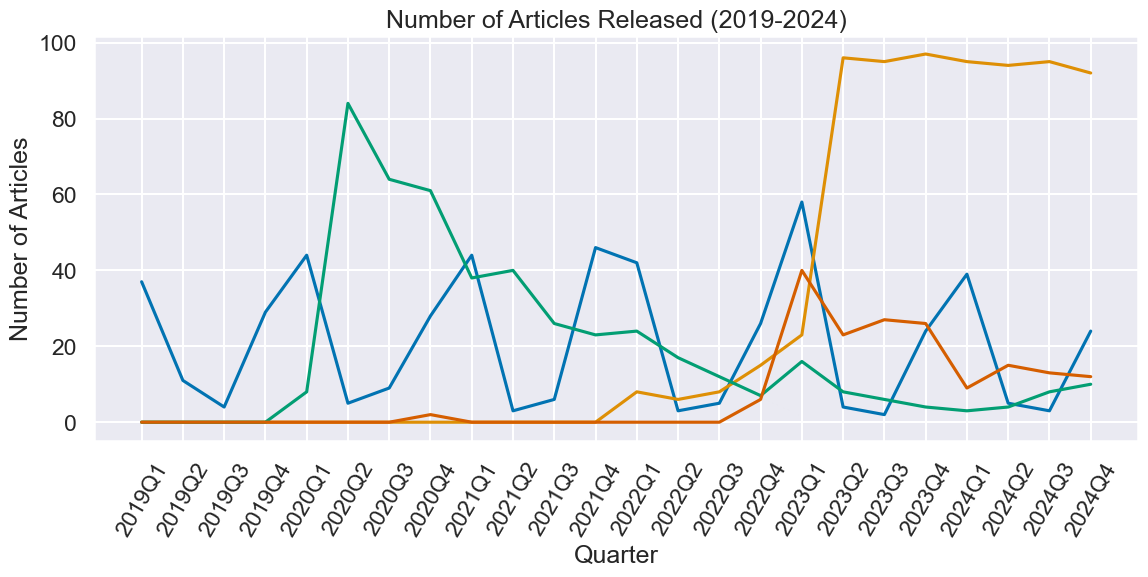

In [9]:
plt.figure(figsize=(12, 5)) # DO NOT MODIFY

for topic in topics:
    sns.lineplot(topic_mentions, x = "Quarter", y = topic_mentions[topic])

# DO NOT MODIFY THE CODE BELOW
# If your solution above is correct, running this cell should produce the plot above.
plt.xticks(rotation=60)
plt.yticks()
plt.ylabel("Number of Articles")
plt.xlabel("Quarter")
plt.title("Number of Articles Released (2019-2024)")
plt.gcf().set_facecolor('white')
plt.show()

<!-- END QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

##  Section 3: Sentiment Analysis

**Sentiment analysis** involves using an NLP model to classify the emotional tone of text. For example, "You're great!" has a positive sentiment, while "I feel horrible" has a negative sentiment.

In this section, I will explore temporal changes in the **sentiment** of NYT articles that mention each topic.

> The sentiment values in this section were computed using a fine-tuned version of the **DistilBERT** model ([GitHub](https://github.com/huggingface/transformers/tree/main/examples/research_projects/distillation), [original paper](https://arxiv.org/abs/1910.01108)).
>
> DistilBERT is a neural network-based language model similar to ChatGPT.


In [10]:
from transformers import pipeline
model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

In [11]:
# Load the model
sentiment_analysis = pipeline(
    "sentiment-analysis", 
    model=model_checkpoint, 
    device=0  # 0 means "first GPU"
)

Device set to use mps:0


In [12]:
# Get the sentiment of a given string
sentiment_1 = sentiment_analysis("I have two dogs.")
print("Example 1: " + str(sentiment_1))

sentiment_2 = sentiment_analysis("I do not have dogs.")
print("Example 2: " + str(sentiment_2))

sentiment_3 = sentiment_analysis("Fortunately, I do not have dogs to worry about.")
print("Example 3: " + str(sentiment_3))

Example 1: [{'label': 'POSITIVE', 'score': 0.9955033659934998}]
Example 2: [{'label': 'NEGATIVE', 'score': 0.9987561702728271}]
Example 3: [{'label': 'POSITIVE', 'score': 0.9975079298019409}]


The model can determine the sentiment of phrases/sentences (not just words). The model measures the phrase's **polarity**, indicating how strongly negative or positive it is on a scale of 0 to 1.

In [13]:
sentiments = sentiment_analysis(["I have two dogs.", "I do not have dogs."])
print(sentiments)

[{'label': 'POSITIVE', 'score': 0.9955033659934998}, {'label': 'NEGATIVE', 'score': 0.9987561702728271}]


<br>

---
###  Part 1

The sentences provided in the previous example have pretty high polarity scores. Let's see how the model behaves with more ambiguous sentences.

I'll write a sentence `less_polar_sentence` that has a polarity score of less than 0.8. This may take some trial and error.

In [14]:
less_polar_sentence = "I went to crossroads for breakfast."
results = sentiment_analysis(less_polar_sentence)
print(results)

[{'label': 'NEGATIVE', 'score': 0.506722092628479}]


<br>

---

###  Part 2

As a first step, I'll obtain the sentiment of the NYT articles that mention these **three** topics: `Zoom`, `New Year`, and `GPT`. 


I'll create a `DataFrame` called `news_df_filtered` that contains all articles from `news_df_dates` that mention `Zoom`, `New Year`, or `GPT`, but do not mention `Wordle`.

In [15]:
condition_zoom_newyear_gpt = (news_df_dates['Zoom'] > 0) | (news_df_dates['New Year'] > 0) | (news_df_dates['GPT Model'] > 0)
condition_no_wordle = news_df_dates['Wordle'] == 0
news_df_filtered = news_df_dates[condition_zoom_newyear_gpt & condition_no_wordle]
news_df_filtered

,web_url,pub_date,lead_paragraph,Year,Month,Minute,Quarter,New Year,Wordle,Zoom,GPT Model
0,https://www.nytimes.com/2019/01/01/us/politics/elizabeth-warren-president.html,2019-01-01T05:18:48+0000,Good Tuesday morning and Happy New Year. Here are some of the stories making news in Washington and politics today.,2019,1,18,2019Q1,1,0,0,0
1,https://www.nytimes.com/2019/01/01/arts/television/whats-on-tv-tuesday-marie-kondo-doctor-who.html,2019-01-01T06:00:04+0000,"Ring in the new year with some organization inspiration, courtesy of Marie Kondo, and the first-ever ""Doctor Who"" New Year’s Day special.",2019,1,0,2019Q1,1,0,0,0
2,https://www.nytimes.com/2019/01/01/travel/three-new-years-resolutions-for-better-travel-in-2019.html,2019-01-01T10:00:06+0000,"It’s not uncommon for people to set unrealistic expectations when making New Year’s resolutions, which likely contributes to most of them failing. Over 90 percent of them do, according to research by the University of Scranton.",2019,1,0,2019Q1,1,0,0,0
3,https://www.nytimes.com/2019/01/01/world/europe/russia-baby-rescue.html,2019-01-01T16:41:24+0000,"MOSCOW — Rescue workers pulled a 10-month-old baby boy alive from a partly collapsed apartment building in central Russia on Tuesday, calling him a ""New Year miracle"" after he survived in the rubble for more than 35 hours in freezing temperatures.",2019,1,41,2019Q1,1,0,0,0
4,https://www.nytimes.com/2019/01/01/world/europe/germany-foreigners-attack.html,2019-01-01T17:57:51+0000,"BERLIN — Targeting foreigners, a man repeatedly drove his car at pedestrians celebrating New Year’s Eve in western Germany, injuring four people before being arrested, the police and prosecutors said Tuesday.",2019,1,57,2019Q1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1879,https://www.nytimes.com/2024/12/30/us/northern-lights-united-states-new-years-eve.html,2024-12-31T01:41:12+0000,Fireworks won’t be the only thing lighting up the sky during New Year celebrations.,2024,12,41,2024Q4,1,0,0,0
1881,https://www.nytimes.com/2024/12/31/world/europe/new-years-eve-edinburgh-hogmanay-weather-canceled.html,2024-12-31T11:14:16+0000,"The famed Hogmanay street party on New Year’s Eve in Edinburgh, the Scottish capital, has been canceled because of forecasts of rain, strong winds and snow.",2024,12,14,2024Q4,1,0,0,0
1882,https://www.nytimes.com/2024/12/31/us/puerto-rico-power-blackout.html,2024-12-31T14:16:12+0000,"A sweeping blackout hit Puerto Rico early Tuesday morning, plunging nearly all of the island into darkness on New Year’s Eve.",2024,12,16,2024Q4,1,0,0,0
1883,https://www.nytimes.com/2024/12/31/world/new-years-eve-photos.html,2024-12-31T15:18:44+0000,"In plazas and parks and bars and homes across the globe, people gathered to commemorate the end of 2024 and welcome the New Year. Bold swimmers plunged into a frigid lake in Switzerland, joggers in Poland took one last whimsical run of the year and fireworks crackled in citie...",2024,12,18,2024Q4,1,0,0,0



1. I will load the file `data/nyt_sentiments.csv` as a `DataFrame` called `sentiment`. 
2. I will set the index of `sentiment` as the `web_url` of each article, which uniquely defines each article.

Note that the model outputs both a label and a score.

For each article, `sentiment` provides an outputted `label` and 0 to 1 sentiment `score`. Scores closer to 1 have a stronger sentiment, while scores closer to 0 are more neutral. I can more efficiently communicate the information in these two columns with a single new column. 

3. I will Add a new column called `article_sentiment` to `sentiment` that provides the existing score if the label is "POSITIVE", and negates the existing score if the label is "NEGATIVE". For example, a score of `0.6` with a label `POSITIVE` would have the value `0.6` in `article_sentiment`, while a score of `0.6` with a label `NEGATIVE` would have the value `-0.6` in `article_sentiment`.

4. In will merge `news_df` with `sentiment` using the `web_url` column, making sure that `news_df` is the left `DataFrame` while `sentiment` is the right `DataFrame`. The merged `DataFrame` should be called `news_df_sentiment`.

5. Finally, I will drop the original `label` and `score` columns.

In [16]:
sentiment = pd.read_csv("data/nyt_sentiments.csv")
sentiment = sentiment.set_index("web_url")
sentiment["article_sentiment"] = sentiment["score"] * sentiment["label"].apply(lambda x: 1 if x == "POSITIVE" else -1)
news_df_sentiment = sentiment.merge(news_df_filtered, on="web_url")
news_df_sentiment.drop(columns=["label", "score"])
news_df_sentiment

,web_url,label,score,article_sentiment,pub_date,lead_paragraph,Year,Month,Minute,Quarter,New Year,Wordle,Zoom,GPT Model
0,https://www.nytimes.com/2020/01/01/opinion/north-korea-nuclear-test.html,NEGATIVE,0.997801,-0.997801,2020-01-01T16:00:09+0000,"Is anyone surprised? On the last day of 2019, after months of threatening the United States to ease its nuclear standoff with ""a bold decision"" by year’s end — or else — the leader of North Korea darkly announced that the country would unveil a new strategic weapon ""in the ne...",2020,1,0,2020Q1,1,0,0,0
1,https://www.nytimes.com/2020/01/01/parenting/money-rage-and-love.html,POSITIVE,0.999756,0.999756,2020-01-01T17:20:06+0000,"Happy New Year! On this first day of 2020, I’m reflecting on the parenting stories that moved me from the past year. What I love about covering this beat is that how we raise children touches on every topic imaginable: Money, privilege, politics, race, business and technology...",2020,1,20,2020Q1,1,0,0,0
2,https://www.nytimes.com/2020/01/01/smarter-living/5-cheap-ish-things-for-your-home-gym.html,POSITIVE,0.999846,0.999846,2020-01-01T23:32:49+0000,"Kick off the new year right and pick up the brand-new Smarter Living book! We’ve pulled together the best of S.L., plus loads of new advice and guidance, to give you smart, actionable life tips on how to improve your career, your home, your finances, your relationships and yo...",2020,1,32,2020Q1,1,0,0,0
3,https://www.nytimes.com/2020/01/01/us/new-year-shootings.html,NEGATIVE,0.944478,-0.944478,2020-01-01T23:21:49+0000,"Just minutes into New Year’s Day, a teenage boy was shot and wounded in the leg on the North Side of St. Louis. A few minutes later, four people were shot in a different neighborhood, three fatally. By morning, the police were investigating 10 shootings, including five deaths...",2020,1,21,2020Q1,1,0,0,0
4,https://www.nytimes.com/2020/01/01/well/move/exercise-physical-activity-workout-time.html,POSITIVE,0.986820,0.986820,2020-01-01T10:00:13+0000,"If, like many of us, your New Year’s resolution is to find more time to exercise, you may be in luck. According to a recent study of how Americans typically spend their waking hours, almost all of us have far more leisure time available than we think we do.",2020,1,0,2020Q1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,https://www.nytimes.com/video/opinion/100000007013675/self-quarantined-for-the-holidays.html,POSITIVE,0.979687,0.979687,2020-03-07T15:50:04+0000,I was stuck inside with my parents during Chinese New Year. Here’s what we did.,2020,3,50,2020Q1,1,0,0,0
1050,https://www.nytimes.com/video/opinion/100000007262438/club-quarantine.html,POSITIVE,0.978342,0.978342,2020-09-22T19:00:19+0000,"When the coronavirus shut down clubs around the world, I found community in a queer dance party on Zoom.",2020,9,0,2020Q3,0,0,1,0
1051,https://www.nytimes.com/video/technology/100000009494471/the-new-chatgpt-hype-vs-reality.html,NEGATIVE,0.996621,-0.996621,2024-05-31T09:05:07+0000,"Our tech columnist reviews GPT-4o, OpenAI’s latest chatbot technology, in its partly finished state.",2024,5,5,2024Q2,0,0,0,1
1052,https://www.nytimes.com/video/us/100000008742122/monterey-park-survivor.html,NEGATIVE,0.995886,-0.995886,2023-01-26T17:49:08+0000,"Mike Zhang, 71, was filming videos of the Lunar New Year celebration at Star Ballroom Dance Studio on his phone just minutes before a gunman entered and killed 11 people on Jan. 21.",2023,1,49,2023Q1,1,0,0,0


<!-- BEGIN QUESTION -->

<br>

---
###  Part 3

I will now visualize the distribution of article sentiment.

Using `seaborn`, I created a histogram to visualize the distribution of `article_sentiment`.

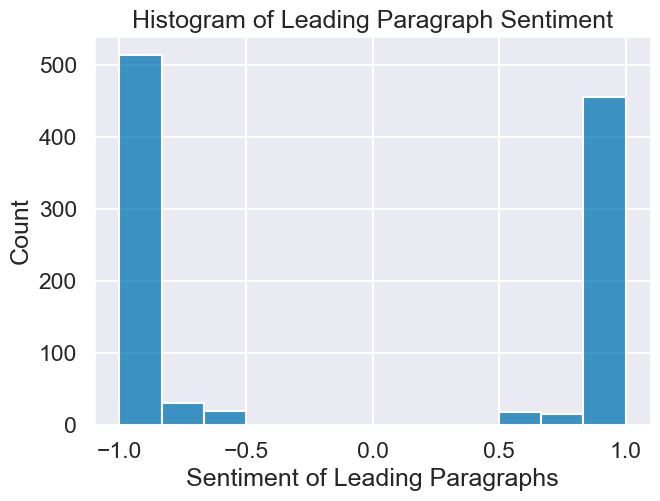

In [17]:
sns.histplot(data=news_df_sentiment, x='article_sentiment')
plt.xlabel('Sentiment of Leading Paragraphs')
plt.title('Histogram of Leading Paragraph Sentiment')
plt.plot();

From the graph above, I could notice that most sentiment of leading paragraphs are either positive or negative. It is hard to find sentiments between -0.7 and 0.7. It shows how hard it is create a sentiment in the range between -0.7 and 0.7.

<!-- END QUESTION -->

<br>

---
###  Part 3

I will audit my data to better understand how well the sentiment analysis model works with our specific dataset. It's good practice to compare our assumptions to model outputs.

I will assign `top_positive` and `top_negative` to `DataFrame`s containing the five articles with the highest `article_sentiment` values and the five lowest `article_sentiment` values, respectively. The `DataFrame`s should have the columns `lead_paragraph` and `article_sentiment`.

In [18]:
top_positive = news_df_sentiment[['lead_paragraph', 'article_sentiment']].sort_values(by='article_sentiment', ascending=False).head(5)
top_negative = news_df_sentiment[['lead_paragraph', 'article_sentiment']].sort_values(by='article_sentiment', ascending=True).head(5)

display(top_positive, top_negative)

,lead_paragraph,article_sentiment
896,"Happy New Year, audiophiles!",0.999876
364,"It’s easy to think about Twyla Tharp and immediately picture her body of work. It’s impressive. Tharp has choreographed more than 150 dances for just about every surface and site imaginable: the concert stage, parks, Broadway, film, ice and now Zoom.",0.999872
487,"Merry Christmas, happy Hanukkah, joyous Kwanzaa and happy New Year.",0.999871
632,"Merry Christmas, happy Hanukkah, joyous Kwanzaa and happy New Year.",0.999871
537,Happy New Year!,0.999869


,lead_paragraph,article_sentiment
820,"The day after Labor Day has got to be one of the worst days in the American calendar year. (Not quite as bad as the first workday after New Year’s, but worth mentioning in the same breath.)",-0.999777
91,"One day this quarantine, who can say which, I encountered the following pieces of information: Zoom, the videoconferencing company, saw its stock hit a new high; Zūm, a ride-sharing venture, cut its work force by a third; and Zume, the robot pizza start-up, failed to raise mo...",-0.999759
178,"In the beginning there was Covid-19, and the tribe of the white collars rent their garments, for their workdays were a formless void, and all their rituals were gone. New routines came to replace the old, but the routines were scattered, and there was chaos around how best to...",-0.999729
936,"There’s a problem with leading artificial intelligence tools like ChatGPT, Gemini and Claude: We don’t really know how smart they are.",-0.999702
186,"I was in Brooklyn on a Zoom meeting in mid-March, when I saw my mom’s name come up on my cellphone. ""Your dad’s not feeling well,"" she said.",-0.999698


<!-- END QUESTION -->

<br>

---

### Continued Visualizing
I'll continue to visualize the `news_df_sentiment` data. The cell below adds a new datetime column `date` to `news_df_sentiment`. The datetime format will make visualization easier.

In [19]:
# Combine the columns into a single date string in 'YYYY-MM-DD' format
news_df_sentiment['date_str'] = (
    news_df_sentiment['Year'].astype(str)
    + '-' + news_df_sentiment['Month'].astype(str)
    + '-' + news_df_sentiment['pub_date'].str[8:10]
)

# Convert the combined string to a datetime object using pd.to_datetime()
news_df_sentiment['date'] = pd.to_datetime(news_df_sentiment['date_str'], format='%Y-%m-%d', errors='coerce')

Below, I will visualize the change in sentiment in the topic `Zoom` over time, using `sns.lineplot` to plot `date` on the x-axis and `article_sentiment` on the y-axis.

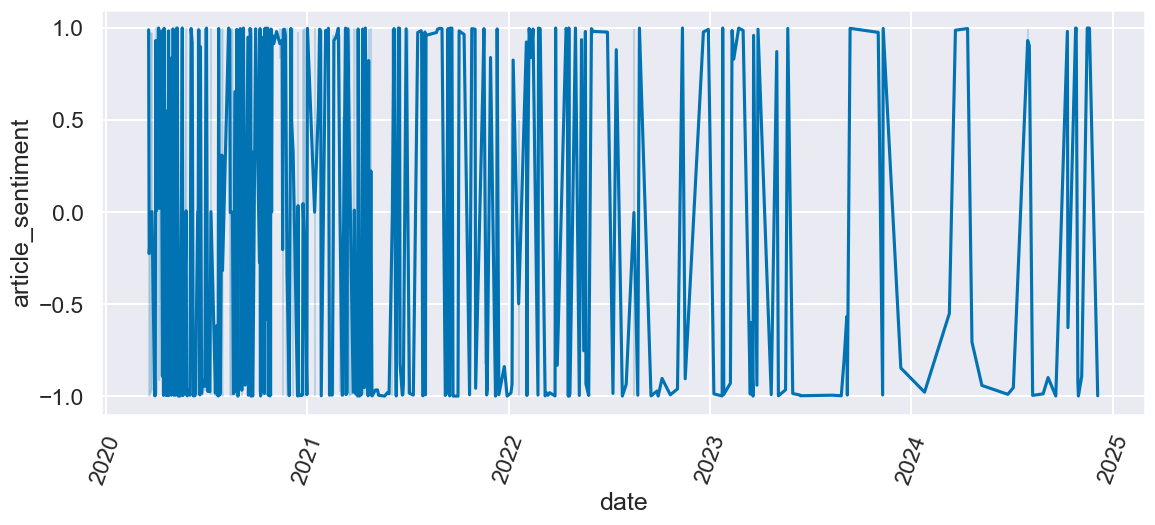

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=news_df_sentiment[news_df_sentiment["Zoom"] > 0], x='date', y='article_sentiment')
plt.xticks(rotation=70);

**This plot is not very pretty!** This isn't because of any errors on your part. Instead, we need to use a different visualization method to understand the data.

<!-- END QUESTION -->

<br>

---

### Takeaways

In this project, I used a language model to evaluate the sentiment of news articles and quantify text data (qualitative data) so that we could perform data analysis on a large set of journalism data. Though I used the [HuggingFace DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english) model, there are thousands of language models available for use, and with rapid innovations in the NLP research space, there are new models frequently being created. In fact, I am using a different model for this homework one year ago, which reflects how quickly the NLP field progresses. 

Different models evaluate sentiment differently. I noticed that the DistilBERT model struggles with evaluating neutral sentences and often gives sentences a high polarity score. When evaluating which models to use in projects, it's useful to test them on small inputs of data to see how they perform, like I did by testing out various sentences! Different models may perform differently (often due to how the model was trained and created), so it's important to understand these differences when deciding what model to use for data.
